In [7]:
# import sys
# sys.path.append('../input/iterativestratification')
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
import copy
import os

import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import (Dense, DenseFeatures, Dropout, 
                                     BatchNormalization, Embedding, Input, Concatenate, Average,
                                     InputLayer, Lambda)
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras import backend as K, Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow_addons.layers import WeightNormalization
from keras.wrappers.scikit_learn import KerasRegressor
import keras

from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.data import DataLoader,  TensorDataset

import random

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from math import log2

print(pd.__version__)
print(tf.__version__)

1.1.4
2.3.0


In [3]:
# Loading data and encoding

folder_path = '/content/drive/My Drive/Data/colabs_data/MOA_kaggle/'
raw_test = pd.read_csv(folder_path + 'test_features.csv')
raw_train = pd.read_csv(folder_path + 'train_features.csv')
raw_targets = pd.read_csv(folder_path + 'train_targets_scored.csv')

# Phân loại dữ liệu
cols_id = ['sig_id']
cols_to_remove = ['cp_type']
cols_fts = [i for i in raw_train.columns if i not in cols_id +cols_to_remove]
cols_gene = [col for col in raw_train.columns if col.startswith("g-")]
cols_cell = [col for col in raw_train.columns if col.startswith("c-")]
cols_experiment = [col for col in cols_fts if col not in cols_gene+cols_cell]
cols_target = [i for i in raw_targets.columns if i not in cols_id]
num_fts, num_labels = len(cols_fts), len(cols_target)

# xử lý categorical
def transform_data(input_data):
    '''Clean data and encoding
        * input_data: table '''
    out = input_data.copy()
    out['cp_dose'] = out['cp_dose'].map({'D1':0, 'D2':1})
    out['cp_time'] = out['cp_time']/72
    
    return out

to_train = transform_data(raw_train[raw_train['cp_type'] != 'ctl_vehicle'])
to_train_targets = raw_targets.iloc[to_train.index]
to_pred  = transform_data(raw_test)
to_pred_non_ctl = to_pred[to_pred['cp_type'] != 'ctl_vehicle']

1  :  20254572.911334965
2  :  17837862.70677919
3  :  17240687.1472074
4  :  16696893.061556797
5  :  16380092.476128293
6  :  16145758.242495641
7  :  15933070.083596867
8  :  15721919.769195586
9  :  15552311.197275728
10  :  15411201.016965305
11  :  15275110.404905742
12  :  15147023.306696098
13  :  15043092.142752526
14  :  14936886.076654375


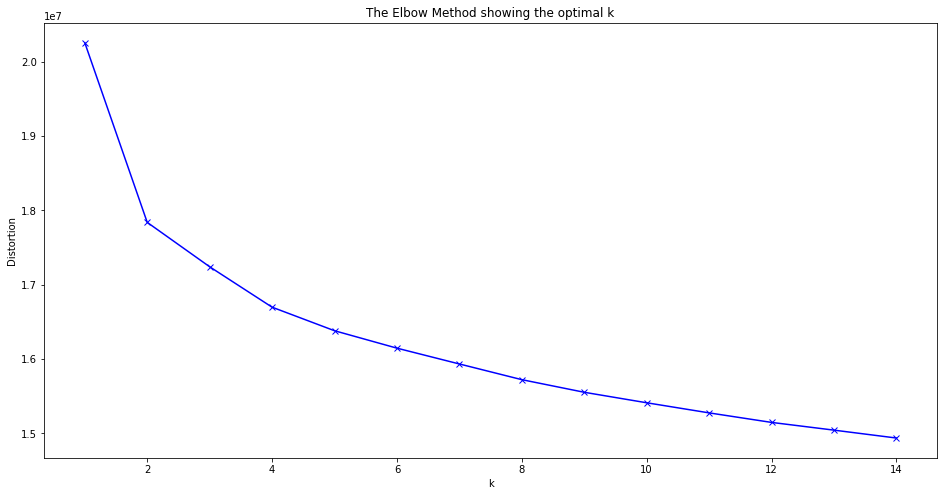

In [12]:
scaler = QuantileTransformer(n_quantiles=100,random_state=0, output_distribution="normal")
scaled_train_fts = scaler.fit_transform(to_train[cols_fts])
# kmean = Kmeans(n_clusters = )
distortions = []
K = range(1,15, 1)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_train_fts)
    distortions.append(kmeanModel.inertia_)
    print(k, " : ",kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [4]:
# preprocessing pipeline
def pipe_line_builder(quantiles_num, pca_dims):
    '''Dựng pipe line cho từng nhóm columns
    :quantiles_num: int: số quantile khi normalise
    :pca_dims: int: số chiều pca'''
    norm = QuantileTransformer(n_quantiles=quantiles_num,random_state=0, output_distribution="normal")
    pca = PCA(n_components = pca_dims)
    # kmean = KMeans(kmean_centroids)
    p_norm_pca = Pipeline([ 
        ('norm', norm),
        ('pca', pca)
    ])
    return FeatureUnion([
        ('norm', norm), 
        ('norm_pca', p_norm_pca) 
        ])

pipe = Pipeline([
    ('norm_pca', ColumnTransformer([
                     ('gene', pipe_line_builder(quantiles_num = 200, pca_dims = 600), cols_gene),
                     ('cell', pipe_line_builder(quantiles_num = 200, pca_dims = 50), cols_cell),
                    ]) 
    ), 
    ('var', VarianceThreshold(0.02)) 
])

pipe = ColumnTransformer([
    ('gene_cell', pipe, cols_gene+ cols_cell),
    ('experiment', 'passthrough', cols_experiment)
])

In [12]:
# Final data
pipe.fit(to_train[cols_fts].append(to_pred[cols_fts]))
X_train = pipe.transform(to_train[cols_fts])
X_pred = pipe.transform(to_pred_non_ctl[cols_fts])
y_train_df = to_train_targets[cols_target]
X_train

array([[ 1.12865013,  0.89757181, -0.43257076, ...,  1.90982532,
         0.33333333,  0.        ],
       [ 0.11963182,  0.66804082,  0.2620229 , ...,  0.04832474,
         1.        ,  0.        ],
       [ 0.77965924,  0.93525417,  1.41545837, ..., -0.8483429 ,
         0.66666667,  0.        ],
       ...,
       [-1.94725399,  0.5723286 , -0.60322335, ..., -0.2740858 ,
         0.33333333,  1.        ],
       [ 0.81585077,  0.40123688,  0.42092442, ..., -1.10770323,
         0.33333333,  0.        ],
       [-1.27014803,  1.56905205, -0.28473651, ..., -0.15900133,
         1.        ,  0.        ]])

In [13]:
class Model(nn.Module):
    def __init__(self, n_features, n_targets, hidden_size=512, dropratio=0.2):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(n_features)
        self.dropout1 = nn.Dropout(dropratio)
        self.dense1 = nn.utils.weight_norm(nn.Linear(n_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropratio)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        # self.batch_norm2a = nn.BatchNorm1d(hidden_size)
        # self.dropout2a = nn.Dropout(dropratio)
        # self.dense2a = nn.utils.weight_norm(nn.Linear(hidden_size, 512))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropratio)
        self.dense3 = nn.utils.weight_norm(nn.Linear( hidden_size, n_targets))
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = self.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = self.relu(self.dense2(x))
        
        # x = self.batch_norm2a(x)
        # x = self.dropout2a(x)
        # x = self.relu(self.dense2a(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
#         x = self.sigmoid(x)
        
        return x

# label smmothing
class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth(targets, n_classes, smoothing=0.0):
        assert 0 <= smoothing <= 1
        with torch.no_grad():
#             targets = targets * (1.0 - smoothing) + 0.5 * smoothing
            targets = targets * (1 - smoothing) + torch.ones_like(targets).to(device) * smoothing / n_classes
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss()._smooth(targets, inputs.shape[1], self.smoothing)

        if self.weight is not None:
            inputs = inputs * self.weight.unsqueeze(0)

        loss = F.binary_cross_entropy_with_logits(inputs, targets)

        return loss

def running_train(X_train, Y_train, X_val, Y_val, dataloader, i_fold=None, seed=None):
    # prepare for train
    model = Model(n_features=X_train.shape[1], n_targets=Y_train.shape[1], hidden_size=hsize, dropratio=dropratio).to(device)
    criterion = SmoothCrossEntropyLoss(smoothing=smoothing)
    metric = lambda inputs, targets : F.binary_cross_entropy((torch.clamp(torch.sigmoid(inputs), p_min, p_max)), targets)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
    if lr_scheduler == 'OneCycleLR' or lr_scheduler == 'both':
        scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=pct_start, div_factor=div_factor, 
                                                    max_lr=1e-2, epochs=nepoch, steps_per_epoch=len(dataloader))
    if lr_scheduler == 'ReduceLROnPlateau' or lr_scheduler == 'both':
        scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=3)
    # train
    min_valmetric = np.inf
    step = 0
    for epoch in range(nepoch):
        train_loss = 0
        train_metric = 0
        for i, (X, Y) in enumerate(dataloader):
            model.train()
            predictions = model(X.to(device=device))
            loss = criterion(predictions, Y.to(device=device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if lr_scheduler == 'OneCycleLR' or lr_scheduler == 'both':
                scheduler1.step()

            train_loss += loss.item()
            train_metric += metric(predictions, Y.to(device=device))

        train_loss /= len(dataloader)
        train_metric /= len(dataloader)
        model.eval()
        predictions = model(X_val.to(device=device))

        val_loss = criterion(predictions, Y_val.to(device=device))
        val_metric = metric(predictions, Y_val.to(device=device))
        if lr_scheduler == 'ReduceLROnPlateau' or lr_scheduler == 'both':
            scheduler2.step(val_metric)
        print('Epoch {}/{}, Train Loss={:5f}, Train Metric={:.5f}, Val Loss={:.5f}, Val Metric={:.5f}'.format(
            epoch + 1, nepoch, train_loss, train_metric, val_loss, val_metric))
        if val_metric.item() < min_valmetric:
            min_valmetric = val_metric.item()
            model_name = 'model_{}_{}.pth'.format(i_fold + 1, seed) if eval_strategy == 'kfold' else 'model_single.pth'
            torch.save(model.state_dict(), model_name)
        elif earlystop:
            step += 1
            if step > earlystop_step:
                break

In [14]:
# Hypter-parameters
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# model
hsize = 1024
dropratio = 0.2

# train
batchsize = 128
lr = 0.001
wd = 1e-5
smoothing = 0.001
p_min = smoothing
p_max = 1 - smoothing
nepoch = 20
earlystop = True
earlystop_step = 10

# lr_scheduler, options: ['OneCycleLR', 'ReduceLROnPlateau', 'both']
lr_scheduler = 'OneCycleLR'
# OneCycleLR
pct_start = 0.1
div_factor = 1e3
# ReduceLROnPlateau
factor=0.5
patience=3

# kfold
nseed = 5
NFOLDS = 10
eval_strategy = 'kfold'

In [15]:
kf = KFold(n_splits= NFOLDS, shuffle = True)

ss= np.zeros([to_pred_non_ctl.shape[0], num_labels])
seed = 0

for i_fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print('Training at fold: ', i_fold)
    tf.keras.backend.clear_session()
    
    # Get data
    fold_X_train, fold_y_train = X_train[train_index], to_train_targets[cols_target].values[train_index]
    
    fold_X_val, fold_y_val = X_train[val_index], to_train_targets[cols_target].values[val_index]
    
    # compile model
    
    
    X_train_tensor = torch.from_numpy(fold_X_train).to(dtype=torch.float32)
    y_train_tensor = torch.from_numpy(fold_y_train).to(dtype=torch.float32)
    X_val_tensor = torch.from_numpy(fold_X_val).to(dtype=torch.float32)
    y_val_tensor = torch.from_numpy(fold_y_val).to(dtype=torch.float32)
    
    
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size= 64, shuffle=True)

    # train
    running_train(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, dataloader, i_fold=i_fold, seed=seed)
    
    # Predict
    model = Model(n_features=X_train_tensor.shape[1], 
                  n_targets=y_train_tensor.shape[1], 
                  hidden_size=hsize, 
                  dropratio=dropratio).to(device)
    model.load_state_dict(torch.load('model_{}_{}.pth'.format(i_fold + 1, seed)))
    model.eval()

    # predict on test
    X_pred_tensor = torch.from_numpy(X_pred).to(dtype=torch.float32)
    print('predict on test...')
    prediction_test = torch.clamp(torch.sigmoid(model(X_pred_tensor.to(device=device)).detach().cpu()), p_min, p_max)
    
    print('  done.\n')
    ss += prediction_test.numpy()

ss = ss/NFOLDS

Training at fold:  0
Epoch 1/20, Train Loss=0.334341, Train Metric=0.33431, Val Loss=0.02063, Val Metric=0.02061
Epoch 2/20, Train Loss=0.019669, Train Metric=0.01961, Val Loss=0.01808, Val Metric=0.01815
Epoch 3/20, Train Loss=0.017989, Train Metric=0.01807, Val Loss=0.01767, Val Metric=0.01777
Epoch 4/20, Train Loss=0.017805, Train Metric=0.01791, Val Loss=0.01782, Val Metric=0.01790
Epoch 5/20, Train Loss=0.017881, Train Metric=0.01797, Val Loss=0.01767, Val Metric=0.01775
Epoch 6/20, Train Loss=0.018006, Train Metric=0.01809, Val Loss=0.01802, Val Metric=0.01809
Epoch 7/20, Train Loss=0.018073, Train Metric=0.01815, Val Loss=0.01796, Val Metric=0.01805
Epoch 8/20, Train Loss=0.018038, Train Metric=0.01812, Val Loss=0.01775, Val Metric=0.01783
Epoch 9/20, Train Loss=0.018066, Train Metric=0.01815, Val Loss=0.01785, Val Metric=0.01793
Epoch 10/20, Train Loss=0.017977, Train Metric=0.01805, Val Loss=0.01767, Val Metric=0.01775


RuntimeError: ignored

MODELING

In [ ]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 7           
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features= X_train.shape[1]
num_targets= num_labels
hidden_size=1500


In [ ]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [ ]:
sub.shape